In [1]:
# -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

import nibabel as nib

import bids
from bids import BIDSLayout
from tqdm import tqdm

import nilearn as nil
from nilearn.plotting import plot_stat_map, show

import matplotlib.pyplot as plt

In [2]:
# information for path, hyperparams..
data_dir = '/home/mybirth0407/datasets/ds000005' # custom directory

In [3]:
bids.config.set_option('extension_initial_dot', True)
layout = BIDSLayout(data_dir, derivatives=True)

In [4]:
def make_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'risky': contrasts['risky'],
        'safe': contrasts['safe'],
        'risky-safe': contrasts['risky'] - contrasts['safe']
    }
    return contrasts

In [5]:
from nilearn import plotting

def plot_contrast(first_level_model):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    
    design_matrix = first_level_model.design_matrices_[0]
    # Call the contrast specification within the function
    contrasts = make_contrasts(design_matrix)
    fig = plt.figure(figsize=(11, 3))
    
    z_maps = []
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(1, len(contrasts), 1 + index)
        z_map = first_level_model.compute_contrast(contrast_val, output_type='z_score')
        plotting.plot_stat_map(
            z_map, display_mode='z', threshold=3.0,
            title=contrast_id, axes=ax, cut_coords=1)
        z_maps.append(z_map)
    return z_maps

# First level analysis using GLM

# Single subject, single run

In [6]:
subject_id = '01'
run_num = 1

image_sample = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    run=run_num,
    extension='nii.gz')

event_sample = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    run=run_num,
    extension='tsv')

In [7]:
df_events = pd.read_table(event_sample[0])
df_events = df_events[['onset', 'duration', 'respcat']]
df_events['respcat'] = df_events['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
df_events.columns = ['onset', 'duration', 'trial_type']

In [8]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(layout.get_tr())
first_level_model = first_level_model.fit(image_sample, events=df_events)
design_matrix = first_level_model.design_matrices_[0]

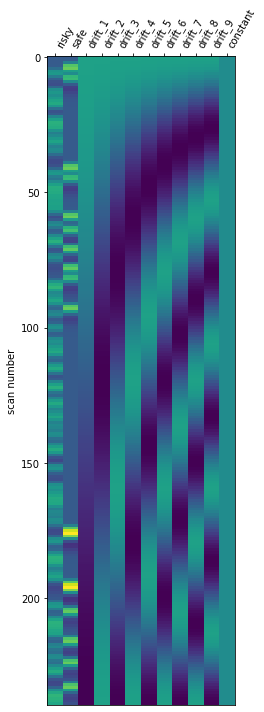

In [9]:
from nilearn.reporting import plot_design_matrix

plot_design_matrix(design_matrix)
plt.show()

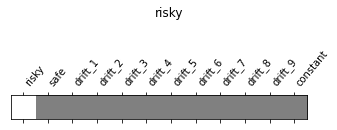

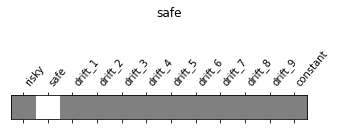

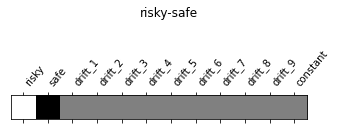

In [10]:
contrasts = make_contrasts(design_matrix)
from nilearn.reporting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix)
    plt.suptitle(key)
plt.show()

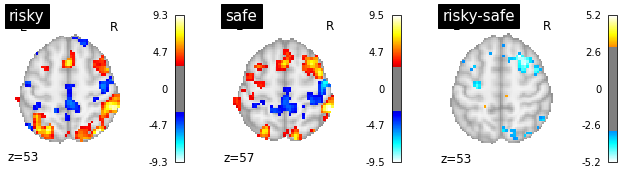

In [11]:
plot_contrast(first_level_model)
plt.show()

# Single subject, multiple run

In [12]:
image_samples = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    extension='nii.gz')

event_samples = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    extension='tsv')

In [13]:
df_events = []

for event_sample in event_samples:
    onsets = pd.read_table(event_sample)
    onsets = onsets[['onset', 'duration', 'respcat']]
    onsets['respcat'] = onsets['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
    onsets.columns = ['onset', 'duration', 'trial_type']
    df_events.append(onsets)

In [14]:
mc = [pd.read_table(confounds)[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']] \
          for confounds in layout.derivatives['fMRIPrep'].get(subject=subject_id, suffix='regressors', extension='.tsv')]

In [15]:
first_level_model = FirstLevelModel(layout.get_tr(), high_pass=.016, hrf_model='glover', noise_model='ols', smoothing_fwhm=6)
first_level_model = first_level_model.fit([nib.load(image_sample) for image_sample in image_samples], events=df_events, confounds=mc)
design_matrix = first_level_model.design_matrices_[0]

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:577: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


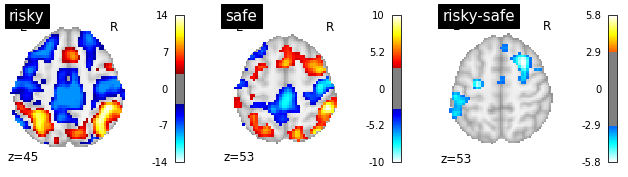

In [16]:
plot_contrast(first_level_model)
plt.show()

# Multiple subject, multiple run using bids format

In [17]:
from nilearn.glm.first_level import first_level_from_bids

models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
    data_dir, layout.get_task()[0], layout.get_space()[0], smoothing_fwhm=6.0, derivatives_folder='derivatives/fmriprep')

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:850: UserWarning: SliceTimingRef not found in file /home/mybirth0407/datasets/ds000005/derivatives/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


In [18]:
# events file preprocessing

for i in range(len(models_events)):
    for j in range(len(models_events[i])):
        onsets = models_events[i][j]
        onsets = onsets[['onset', 'duration', 'respcat']]
        onsets['respcat'] = onsets['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
        onsets.columns = ['onset', 'duration', 'trial_type']
        models_events[i][j] = onsets

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [19]:
# confounds file preprocessing

for i in range(len(models_confounds)):
    for j in range(len(models_confounds[i])):
        mc = models_confounds[i][j]
        mc = mc[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        models_confounds[i][j] = mc

In [20]:
first_level_models = [models[i].fit([nib.load(run_img) for run_img in models_run_imgs[i]], events=models_events[i], confounds=models_confounds[i]) \
                          for i in tqdm(range(len(models)))]

100%|██████████| 16/16 [05:45<00:00, 21.59s/it]


/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:577: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


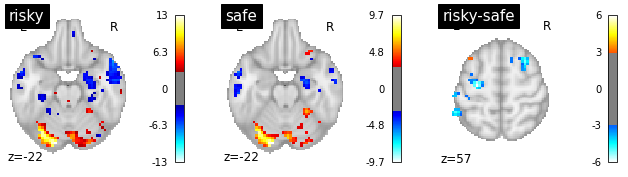

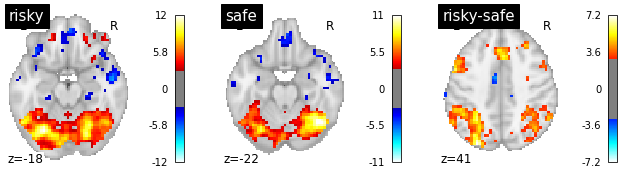

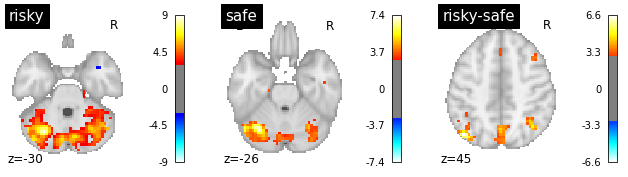

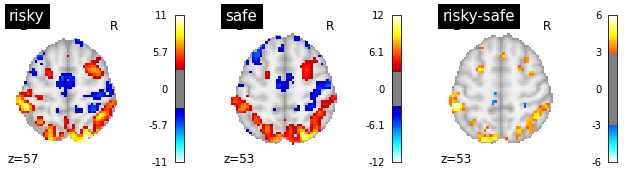

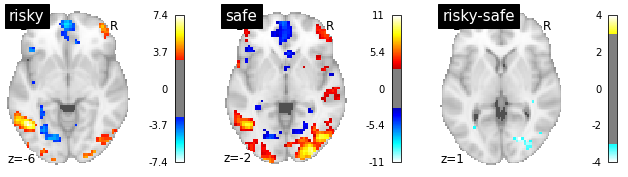

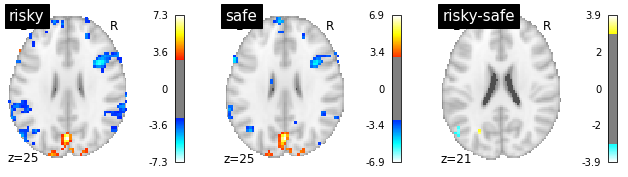

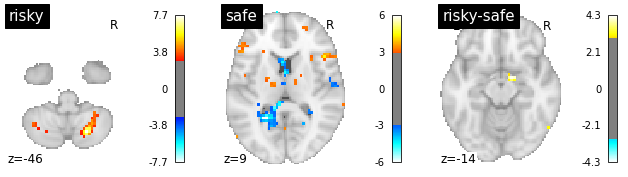

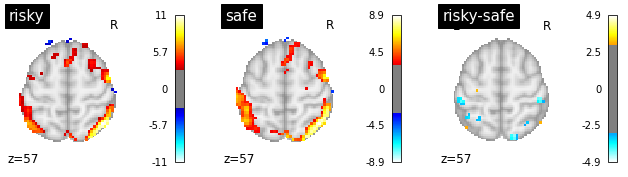

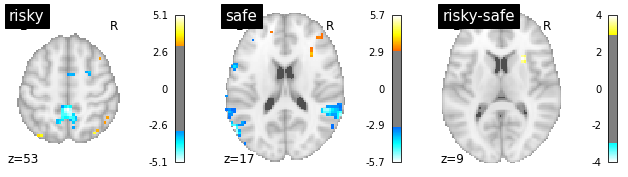

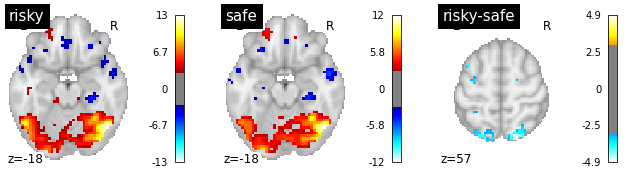

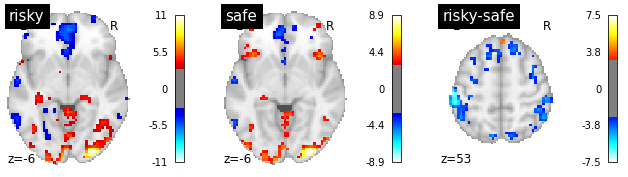

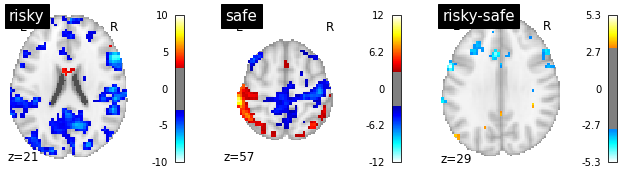

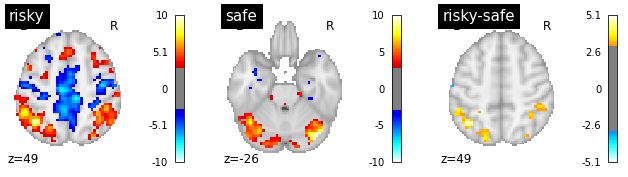

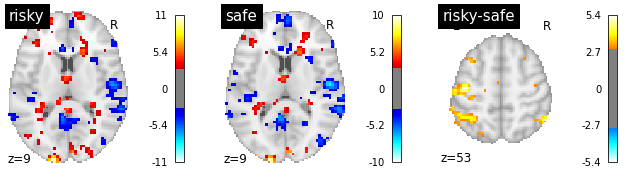

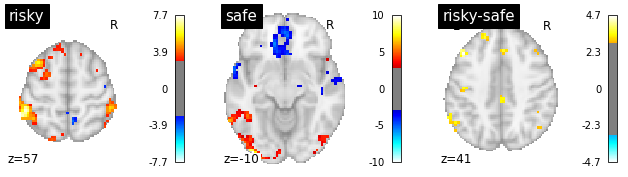

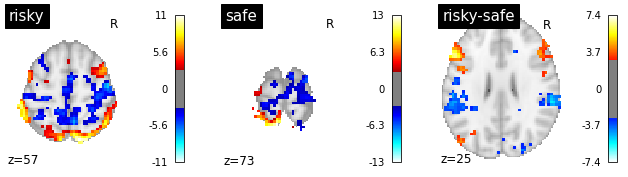

In [21]:
z_maps = []
for flm in first_level_models:
    z_maps.append(plot_contrast(flm))
    plt.show()

In [22]:
first_level_dir = Path('results/first_level')

import os
if not os.path.exists(first_level_dir):
    os.makedirs(first_level_dir)
    
for i, z_map in enumerate(z_maps):
    nib.save(z_map[2], first_level_dir / f'risky_safe_subject_{i+1:02d}.nii') # z_map[0] is riksy, z_map[1] is safe, z_map[2] is risky-safe

# Second level analysis using GLM (required result image of first level analysis using GLM)

In [23]:
second_level_input = [z_map[2] for z_map in z_maps]
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

In [24]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(smoothing_fwhm=6.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

In [25]:
z_map = second_level_model.compute_contrast(output_type='z_score')

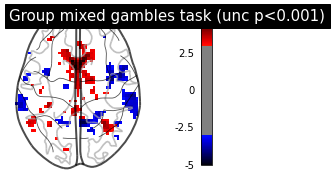

In [26]:
from scipy.stats import norm

p_val = 0.001
p001_unc = norm.isf(p_val)
title = ('Group mixed gambles task (unc p<0.001)')
display = plotting.plot_glass_brain(
    z_map, threshold=p001_unc, colorbar=True, display_mode='z', plot_abs=False,
    title=title)
plotting.show()

In [27]:
import numpy as np
from nilearn.image import get_data, math_img

p_val = second_level_model.compute_contrast(output_type='p_value')
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img('-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)), img=p_val)

<string>:1: RuntimeWarning: divide by zero encountered in log10


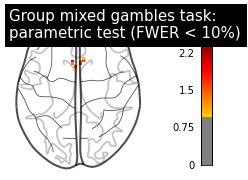

In [28]:
cut_coords = [0]
threshold = 1
title = ('Group mixed gambles task: \n'
         'parametric test (FWER < 10%)')
display = plotting.plot_glass_brain(
    neg_log_pval, colorbar=True, display_mode='z', plot_abs=False, vmax=3,
    cut_coords=cut_coords, threshold=threshold, title=title)
plotting.show()

In [29]:
from nilearn.glm.second_level import non_parametric_inference

neg_log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(second_level_input,
                             design_matrix=design_matrix,
                             model_intercept=True, n_perm=1000,
                             two_sided_test=False,
                             smoothing_fwhm=6.0, n_jobs=1)

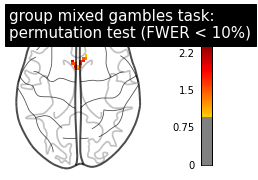

In [30]:
title = ('group mixed gambles task: \n'
         'permutation test (FWER < 10%)')
display = plotting.plot_glass_brain(
    neg_log_pvals_permuted_ols_unmasked, colorbar=True, vmax=3,
    display_mode='z', plot_abs=False, cut_coords=cut_coords,
    threshold=threshold, title=title)
plotting.show()

In [31]:
second_level_dir = Path('results/second_level')
if not os.path.exists(second_level_dir):
    os.makedirs(second_level_dir)
    
nib.save(z_map, second_level_dir / 'z_map.nii')
nib.save(neg_log_pval, second_level_dir / 'neg_log_pval.nii')
nib.save(neg_log_pvals_permuted_ols_unmasked, second_level_dir / 'neg_log_pvals_permuted_ols_unmasked.nii')